# of years tested: 1.00
Win Rate: 0.71
R-Ratio: 0.52
Expectancy Per $1 of Risk: 0.09
% Risk per Trade: % 2.00
# of Simulations: 10000
# of Trades: 240.00
Risk-Free Rate: 5.50%
Trades per Month: 20


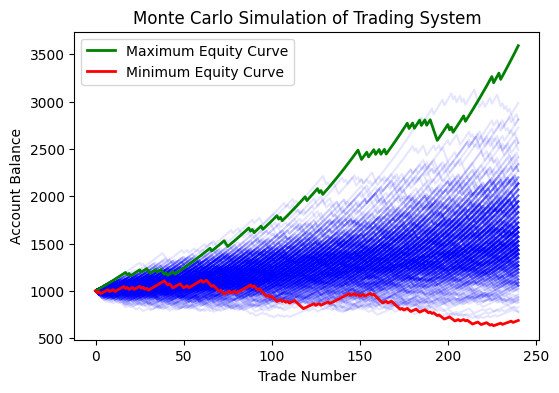

Starting Balance: 1000.00
Mean Final Balance: 1541.76
Standard Deviation: 333.49
Minimum Final Balance: 686.68
Maximum Final Balance: 3590.95
% of > Mean Balance: % 45.31
Maximum Drawdown of Worst Case: 0.43
Mean Maximum Drawdown: 0.14
99th Percentile Drawdown: 0.29
Max Consecutive Wins: 42
Max Consecutive Losses: 13
% of accounts underwater: % 3.19
Sharpe Ratio: 1.75
Sortino Ratio: 3.42


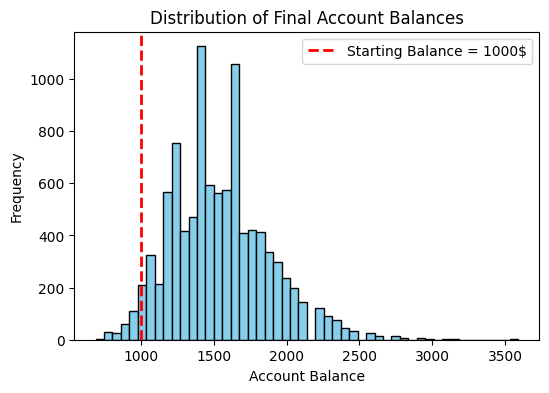

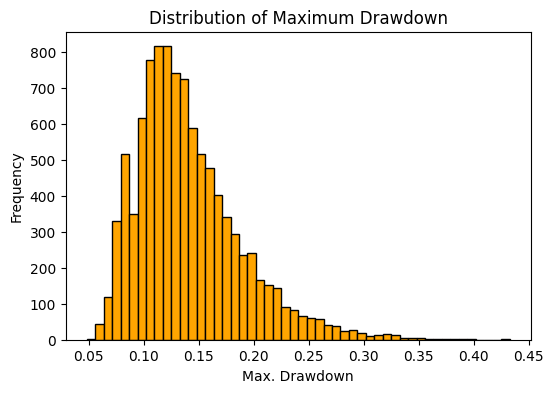

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

def calculate_drawdown(balances):
    peak = balances[0]
    drawdowns = []
    for balance in balances:
        if balance > peak:
            peak = balance
        drawdown = (peak - balance) / peak
        drawdowns.append(drawdown)
    return drawdowns

def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate / 12  # Aylık risk-free oran
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    return sharpe_ratio * np.sqrt(12)  # Sharpe oranını yıllıklaştır

def calculate_sortino_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate / 12  # Aylık risk-free oran
    downside_returns = excess_returns[excess_returns < 0]
    if len(downside_returns) == 0:
        return np.nan  # Eğer downside return yoksa, Sortino oranı tanımlı değil
    downside_deviation = np.std(downside_returns)
    sortino_ratio = np.mean(excess_returns) / downside_deviation
    return sortino_ratio * np.sqrt(12)  # Sortino oranını yıllıklaştır

def monte_carlo_simulation(win_rate, reward_to_risk, risk_per_trade, num_simulations, num_trades, trades_per_month, risk_free_rate):
    all_balances = []
    final_balances = []
    max_drawdowns = []
    all_monthly_returns = []
    max_consecutive_wins = []
    max_consecutive_losses = []
    total_numof_account_underwater = 0

    start_balance = 1000

    for _ in range(num_simulations):
        balance = start_balance
        balances = [balance]
        monthly_returns = []
        consecutive_wins = 0
        consecutive_losses = 0
        max_wins = 0
        max_losses = 0
        
        for trade in range(1, num_trades + 1):
            if np.random.rand() <= win_rate:
                # Kazanılan trade
                balance += balance * risk_per_trade * reward_to_risk
                consecutive_wins += 1
                consecutive_losses = 0
            else:
                # Kaybedilen trade
                balance -= balance * risk_per_trade
                consecutive_losses += 1
                consecutive_wins = 0

            # Maksimum ardışık kazanç ve kayıpların güncellenmesi
            if consecutive_wins > max_wins:
                max_wins = consecutive_wins
            if consecutive_losses > max_losses:
                max_losses = consecutive_losses

            # Aylık getiri hesaplaması
            if trade % trades_per_month == 0:
                if len(balances) >= trades_per_month:
                    monthly_return = balance / balances[-trades_per_month] - 1
                else:
                    monthly_return = balance / start_balance - 1
                monthly_returns.append(monthly_return)

            balances.append(balance)

        # Başlangıç bakiyesinin altına düşen hesap sayısını takip
        if balance < start_balance:
            total_numof_account_underwater += 1
        
        all_balances.append(balances)
        final_balances.append(balance)
        max_drawdowns.append(max(calculate_drawdown(balances)))
        all_monthly_returns.append(monthly_returns)
        max_consecutive_wins.append(max_wins)
        max_consecutive_losses.append(max_losses)

    # Rastgele 500 simülasyonun grafiklerinin çizilmesi
    random_indices = random.sample(range(num_simulations), min(500, num_simulations))

    # -- 1) Equity Curves Grafiği --
    plt.figure(figsize=(6, 4))
    for idx in random_indices:
        plt.plot(all_balances[idx], color='blue', alpha=0.1)
    
    # En yüksek ve en düşük final balance'a sahip eğrilerin çizilmesi
    plt.plot(all_balances[np.argmax(final_balances)], color='green', linewidth=2, label='Maximum Equity Curve')
    plt.plot(all_balances[np.argmin(final_balances)], color='red', linewidth=2, label='Minimum Equity Curve')
    plt.title('MC Simulation of the System')
    plt.xlabel('Trade Number')
    plt.ylabel('Account Balance')
    plt.legend()
    plt.show()

    # -- İstatistiksel Özetler --
    max_drawdown_worst_case = max(max_drawdowns)
    mean_drawdown = np.mean(max_drawdowns)
    drawdown_99_percentile = np.percentile(max_drawdowns, 99)
    mean_balance = np.mean(final_balances)
    pct_above_mean = (sum(1 for x in final_balances if x > mean_balance) / len(final_balances)) * 100
    
    print(f'Starting Balance: {start_balance:.2f}')
    print(f'Mean Final Balance: {np.mean(final_balances):.2f}')
    print(f'Standard Deviation: {np.std(final_balances):.2f}')
    print(f'Minimum Final Balance: {np.min(final_balances):.2f}')
    print(f'Maximum Final Balance: {np.max(final_balances):.2f}')
    print(f'% of > Mean Balance: % {np.max(pct_above_mean):.2f}')
    print(f'Maximum Drawdown of Worst Case: {max_drawdown_worst_case:.2f}')
    print(f'Mean Maximum Drawdown: {mean_drawdown:.2f}')
    print(f'99th Percentile Drawdown: {drawdown_99_percentile:.2f}')
    print(f'Max Consecutive Wins: {np.max(max_consecutive_wins)}')
    print(f'Max Consecutive Losses: {np.max(max_consecutive_losses)}')
    print(f'% of accounts underwater: % {(total_numof_account_underwater/num_simulations*100):.2f}')
        # -- Sharpe ve Sortino Oranları --
    all_monthly_returns_flat = np.concatenate(all_monthly_returns)
    sharpe_ratio = calculate_sharpe_ratio(all_monthly_returns_flat, risk_free_rate)
    sortino_ratio = calculate_sortino_ratio(all_monthly_returns_flat, risk_free_rate)
    
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    print(f'Sortino Ratio: {sortino_ratio:.2f}')

    # -- 2) Final Balances Histogramı + Dikey Çizgi (1000$) --
    plt.figure(figsize=(6, 4))
    plt.hist(final_balances, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(x=start_balance, color='red', linestyle='--', linewidth=2, label='Starting Balance = 1000$')
    plt.title('Distribution of Final Account Balances')
    plt.xlabel('Account Balance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # -- 3) Maximum Drawdown Dağılımı (Yatay Histogram) --
    plt.figure(figsize=(6, 4))
    plt.hist(max_drawdowns, bins=50, orientation='vertical', color='orange', edgecolor='black')
    plt.title('Distribution of Maximum Drawdown')
    # İstenilen gibi X ekseni frekans, Y ekseni drawdown olsun:
    plt.xlabel('Max. Drawdown')
    plt.ylabel('Frequency')
    plt.show()



# Örnek kullanım
years = 1
win_rate = 0.715 # Kazanma oranı
reward_to_risk = 226/431 # Ödül-zarar oranı
expectancy = win_rate * reward_to_risk - (1 - win_rate)
risk_per_trade = 0.02  # Trade başına risk
num_simulations = 10000  # Simülasyon sayısı
trades_per_month = 20  # Aylık trade sayısı
num_trades = 12 * trades_per_month * years  # Toplam trade sayısı

risk_free_rate = 0.055  # Yıllık risksiz faiz oranı

print(f'# of years tested: {years:.2f}')
print(f'Win Rate: {win_rate:.2f}')
print(f'R-Ratio: {reward_to_risk:.2f}')
print(f'Expectancy Per $1 of Risk: {expectancy:.2f}')
print(f'% Risk per Trade: % {risk_per_trade*100:.2f}')
print(f'# of Simulations: {num_simulations:.0f}')
print(f'# of Trades: {num_trades:.2f}')
print(f'Risk-Free Rate: {risk_free_rate:.2%}')
print(f'Trades per Month: {trades_per_month}')

# Monte Carlo Simülasyonunu çalıştır
monte_carlo_simulation(
    win_rate, 
    reward_to_risk, 
    risk_per_trade, 
    num_simulations, 
    num_trades, 
    trades_per_month, 
    risk_free_rate
)
